<a href="https://colab.research.google.com/github/SajlaKM/CancerClassifier/blob/main/Classification_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras numpy matplotlib scikit-learn


In [2]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [4]:
drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/GitHub dataset /dataset.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(DATASET_PATH, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted files:", os.listdir(extract_path))

Mounted at /content/drive
Extracted files: ['Training', 'Testing']


In [5]:
!pip uninstall -y tensorflow keras
!pip install tensorflow keras


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Define constants
image_size = (224, 224)  # ViT uses 224x224 images
batch_size = 32
num_classes = 4  # glioma, meningioma, pituitary, no tumor

# Define dataset path
train_path = "/content/dataset/Training"

# Load images & labels
images = []
labels = []

for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)

    if not os.path.isdir(label_path):
        continue  # Ensure it's a directory

    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        if os.path.isdir(img_path):
            continue  # Skip directories

        try:
            img = load_img(img_path, target_size=image_size)  # Load image
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(label)  # Store class
        except Exception as e:
            print(f"Skipping {img_path}: {e}")

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

# Encode labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes)

# Split dataset into Train (80%) & Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Load Pretrained ViT Model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (optional for faster training)
base_model.trainable = False

# Custom Classification Head
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation="softmax")(x)  # Final layer

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32)
#history = model.fit(X_train[:100], y_train[:100], validation_data=(X_val[:20], y_val[:20]), epochs=2, batch_size=16)
# Evaluate Model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Save Model
model.save("brain_tumor_vit.h5")


Total images loaded: 5712
Total labels loaded: 5712
Epoch 1/4
143/143 ━━━━━━━━━━━━━━━━━━━━ 1215s 8s/step - accuracy: 0.4018 - loss: 8.4806 - val_accuracy: 0.4926 - val_loss: 1.0339
Epoch 2/4
143/143 ━━━━━━━━━━━━━━━━━━━━ 1200s 8s/step - accuracy: 0.4779 - loss: 1.1236 - val_accuracy: 0.6238 - val_loss: 1.0738
Epoch 3/4
143/143 ━━━━━━━━━━━━━━━━━━━━ 1193s 8s/step - accuracy: 0.5319 - loss: 1.0695 - val_accuracy: 0.4567 - val_loss: 1.1257
Epoch 4/4
143/143 ━━━━━━━━━━━━━━━━━━━━ 1200s 8s/step - accuracy: 0.4470 - loss: 1.1378 - val_accuracy: 0.5057 - val_loss: 1.0509
36/36 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.5115 - loss: 1.0301


Validation Accuracy: 50.57%


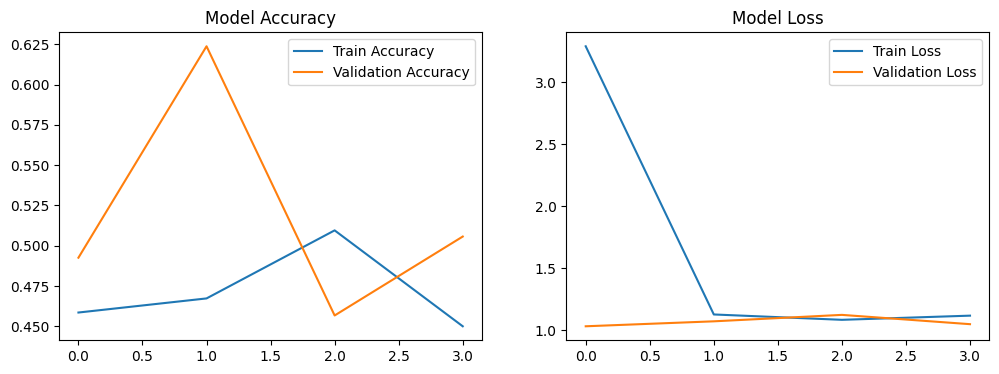

In [4]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()
